# Covid19 USA States

Load a CSV file, about Covid-19 and show it's content

In [1]:
import pandas as pd
from datetime import date, timedelta

In [2]:
yesterday = date.today() - timedelta(days = 1)
yesterday = yesterday.strftime("%m-%d-%Y")
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/{}.csv".format(yesterday))
top = df.sort_values('Confirmed', ascending=False)
top

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
36,New York,US,2020-05-01 02:32:32,42.1657,-74.9481,304372,23587,54771,226014.0,36,1805.180883,900636.0,66369.0,7.749399,84000036,USA,5341.525797,21.805225
34,New Jersey,US,2020-05-01 02:32:32,40.2989,-74.5210,118652,7228,15642,95782.0,34,1335.841724,247918.0,NaN,6.091764,84000034,USA,2791.181004,NaN
25,Massachusetts,US,2020-05-01 02:32:32,42.2302,-71.5301,62205,3562,0,58643.0,25,906.280104,275647.0,5942.0,5.726228,84000025,USA,4015.969645,9.552287
17,Illinois,US,2020-05-01 02:32:32,40.3495,-88.9861,52918,2355,0,50563.0,17,450.916536,269867.0,NaN,4.450282,84000017,USA,2299.548223,NaN
5,California,US,2020-05-01 02:32:32,36.1162,-119.6816,50130,2031,0,48099.0,6,127.854538,625337.0,NaN,4.051466,84000006,USA,1594.896734,NaN
43,Pennsylvania,US,2020-05-01 02:32:32,40.5908,-77.2098,47971,2475,0,45496.0,42,381.100389,221365.0,NaN,5.159367,84000042,USA,1758.610151,NaN
26,Michigan,US,2020-05-01 02:32:32,43.3266,-84.5361,41379,3789,8342,29248.0,26,519.363058,180267.0,NaN,9.156819,84000026,USA,2262.597463,NaN
11,Florida,US,2020-05-01 02:32:32,27.7663,-81.6868,33690,1268,0,32422.0,12,158.671055,382405.0,5795.0,3.763728,84000012,USA,1801.027156,17.200950
49,Texas,US,2020-05-01 02:32:32,31.0545,-97.5635,28727,812,12507,15408.0,48,124.983897,314790.0,NaN,2.826609,84000048,USA,1369.571514,NaN
22,Louisiana,US,2020-05-01 02:32:32,31.1695,-91.8678,28001,1905,17303,8793.0,22,609.079396,161309.0,NaN,6.803328,84000022,USA,3508.802841,NaN


Plot the number of infected in each state

In [3]:
import matplotlib.pyplot as plt
import numpy as np

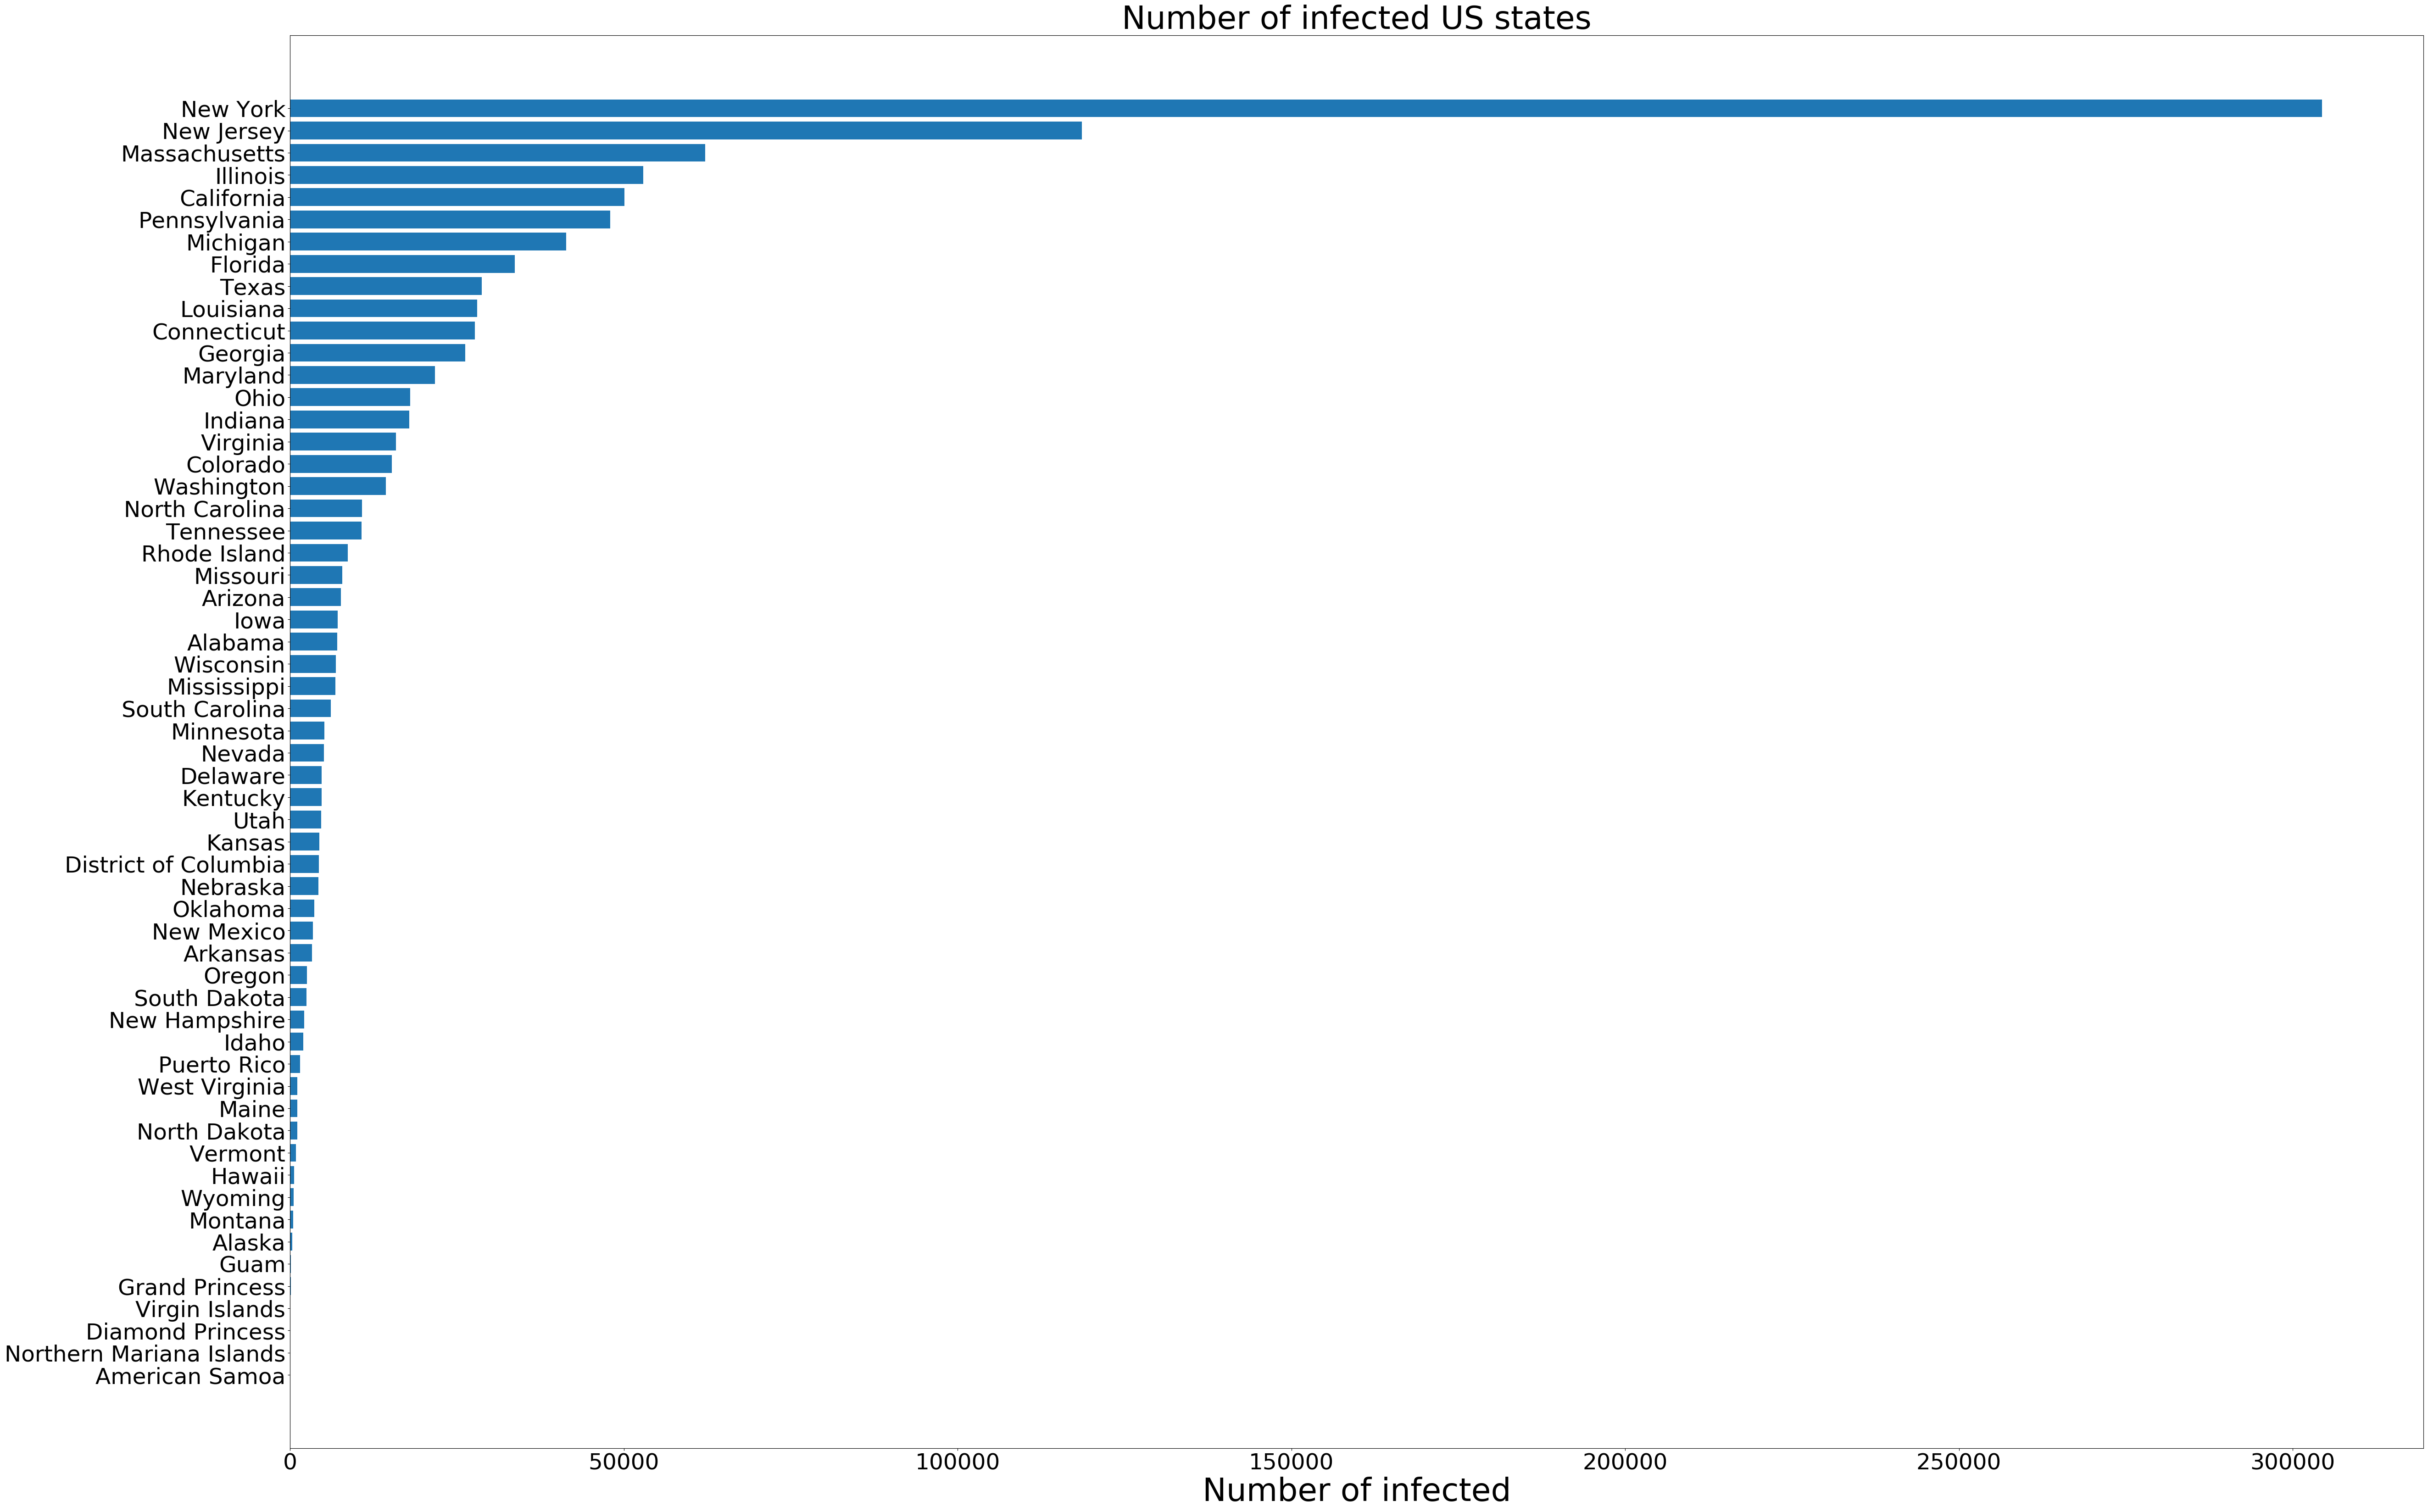

In [4]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(60,40))
xlabel = top.Province_State
ylabel = top.Confirmed
pos = np.arange(len(ylabel))

ax.barh(pos, ylabel, align='center')
ax.set_yticks(pos)
ax.set_yticklabels(xlabel, fontsize=35)
ax.invert_yaxis()
ax.set_xlabel('Number of infected', fontsize=50)
ax.set_title('Number of infected US states', fontsize=50)
plt.xticks(fontsize=35)
plt.show()

Number of infected, recovered, deaths and hospitalized of top states

In [5]:
confirmed = []
recovered = []
deaths = []
hospitalized = []
xlabel = []
legend = ['Confirmed', 'Recovered', 'Deaths', 'Hopitalized']
top_n = 5

for row in top.head(top_n).iterrows():
    confirmed.append(row[1].Confirmed)
    recovered.append(row[1].Recovered)
    deaths.append(row[1].Deaths)
    hospitalized.append(row[1].People_Hospitalized)
    xlabel.append(row[1].Province_State)

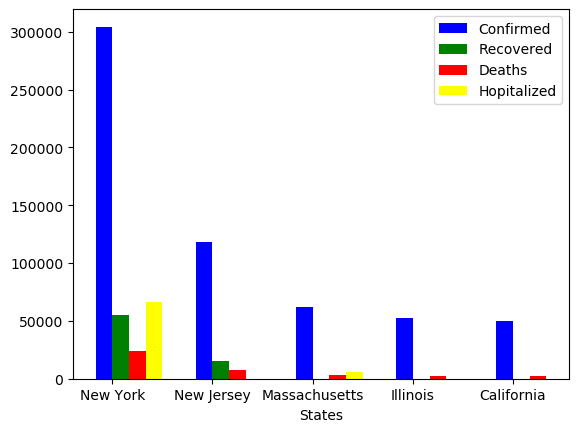

In [6]:
index = np.arange(top_n)
width = 1 / (top_n + 1)

plt.bar(index, confirmed, width, color='blue', label=legend[0])
plt.bar(index + width, recovered, width, color='green', label=legend[1])
plt.bar(index + width * 2, deaths, width, color='red', label=legend[2])
plt.bar(index + width * 3, hospitalized, width, color='yellow', label=legend[3])

plt.xlabel('States')
plt.xticks(index + width / 2, xlabel)
plt.legend(loc="upper right")
plt.show()

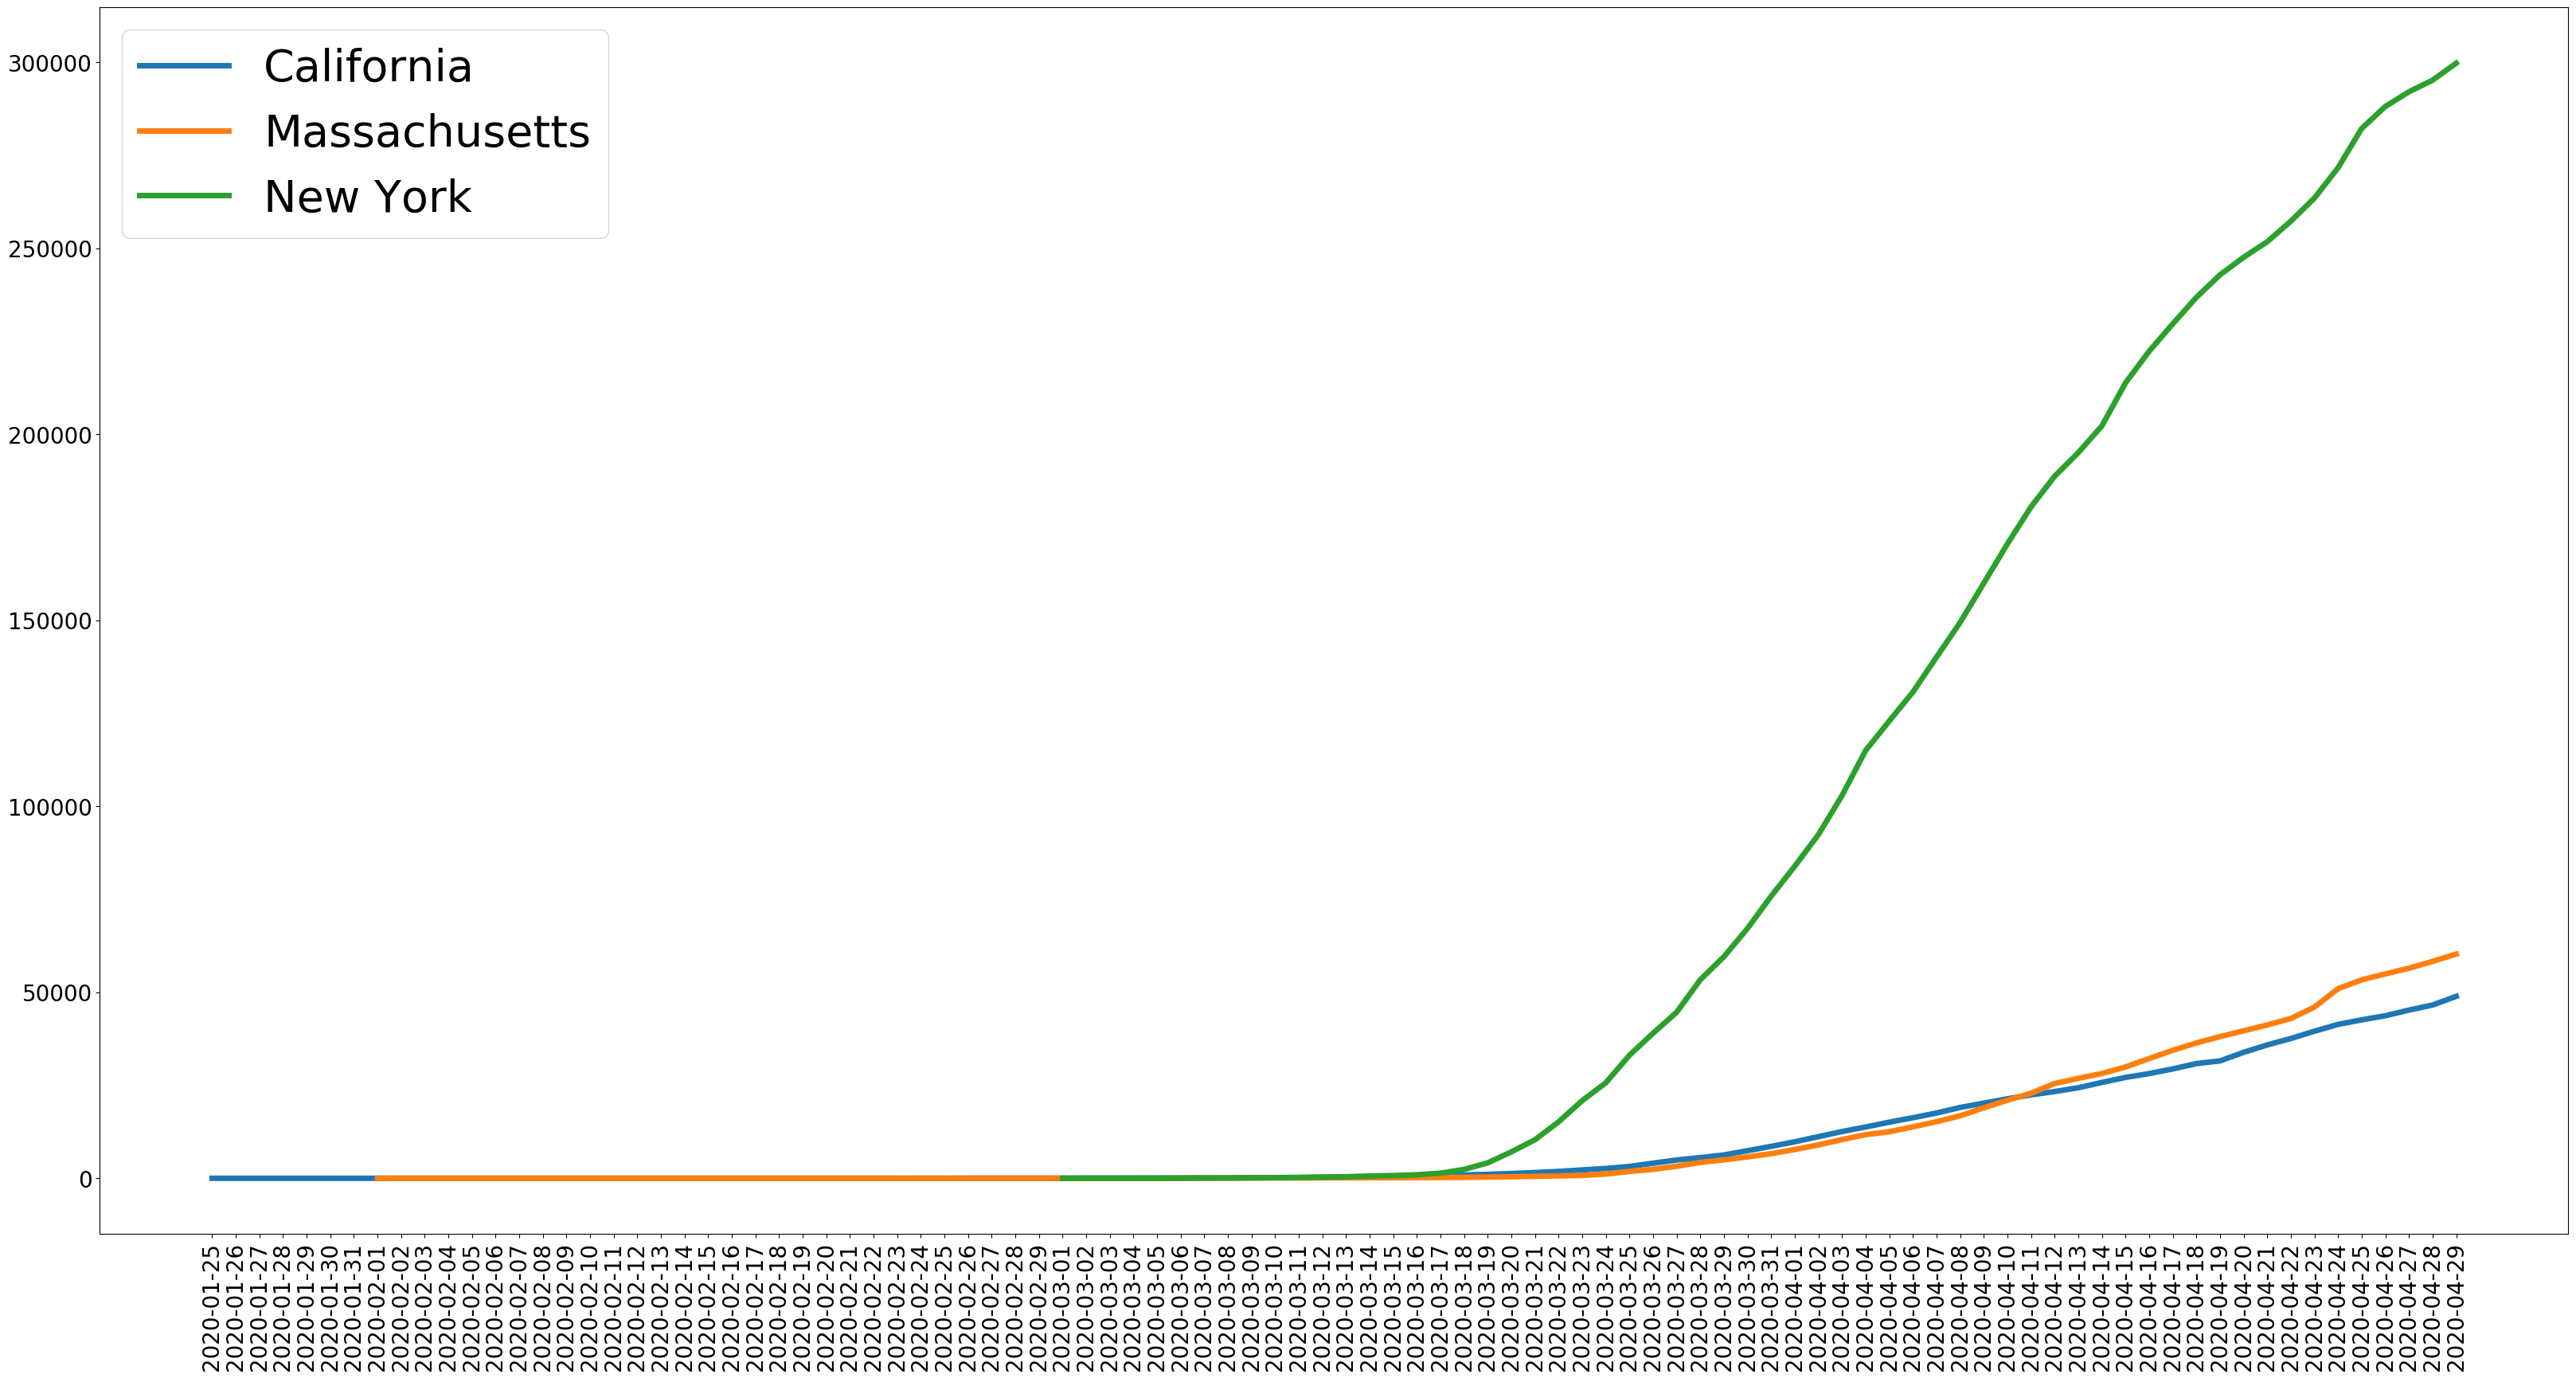

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
states = ['California', 'Massachusetts', 'New York']
dates = []
cases = []

for state in states:
    flag = df['state'] == state
    state = df[flag]
    state.sort_values('date')
    dates.append(state['date'].to_list())
    cases.append(state['cases'].to_list())

fig, ax = plt.subplots(figsize=(40,20))
for i in range(len(states)):
    ax.plot(dates[i], cases[i], label=states[i], linewidth=5.0)
ax.legend(loc='upper left', fontsize=40)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(rotation=90, labelsize=20)
plt.show()

In [8]:
import sys
import os
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *

Starting qgis application

In [9]:
QgsApplication.setPrefixPath(r'C:\\OSGeo4W64\\apps\\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W64\apps\qgis\python\plugins')

In [10]:
project = QgsProject.instance()

Load shapefile of USA States

In [11]:
# load map layer
usa_path = "data/usa_states_map/tl_2017_us_state.shp"
layer = QgsVectorLayer(usa_path, 'USA States Map', 'ogr')
usa_layer = layer.clone()

if not usa_layer.isValid():
    print("Failed to load the layer!")
else:
    crs = QgsCoordinateReferenceSystem('EPSG:5071')
    usa_layer.setCrs(crs)
    project.addMapLayer(usa_layer)

Load CSV file of covid19 data and create a vector layer

In [12]:
dates = ['04-15-2020', '04-22-2020', '04-29-2020']

def loadCSVVectorLayer(date):
    # load covid-19 numbers 04-13-2020
    covid_path = "file:///E:/TA-Cartografia/data/covid19-usa/{}.csv".format(date)
    layer_name = 'covid{}'.format(date)
    covid_layer = QgsVectorLayer(covid_path, layer_name, 'delimitedtext')

    if not covid_layer.isValid():
        print('Layer failed to load!')
    else:
        project.addMapLayer(covid_layer)
        
for date in dates:
    loadCSVVectorLayer(date)

Join CSV layers to USA layer

In [13]:
targetField = 'NAME'
joinField = 'Province_State'

In [14]:
def joinCSVSHPVectorLayers(csv_layer):
    joinObject = QgsVectorLayerJoinInfo()
    joinObject.setJoinFieldName(joinField)
    joinObject.setTargetFieldName(targetField)
    joinObject.setJoinLayerId(csv_layer.id())
    joinObject.setUsingMemoryCache(True)
    joinObject.setJoinLayer(csv_layer)
    flag = usa_layer.addJoin(joinObject)
    return flag
    
for date in dates:
    layer_name = 'covid{}'.format(date)
    csv_layer = project.mapLayersByName(layer_name)[0]
    flag = joinCSVSHPVectorLayers(csv_layer)

Add a new field to the vector layer

In [15]:
caps = usa_layer.dataProvider().capabilities()

if caps & QgsVectorDataProvider.AddAttributes:
    new_fields = [
        QgsField("d1", QVariant.Int),
        QgsField("d2", QVariant.Int),
        QgsField("delta", QVariant.Int)
    ]
    res = usa_layer.dataProvider().addAttributes(new_fields)
usa_layer.updateFields()

Remove features without confirmed cases

In [16]:
del_ids = []

def removeFeature(conf1, conf2, conf3):
    flag1 = conf1 is None or conf1 == 0
    flag2 = conf2 is None or conf2 == 0
    flag3 = conf3 is None or conf3 == 0
    return flag1 or flag2 or flag3

if caps & QgsVectorDataProvider.DeleteFeatures:
    for feature in usa_layer.getFeatures():
        conf1 = feature['covid{}_Confirmed'.format(dates[0])]
        conf2 = feature['covid{}_Confirmed'.format(dates[1])]
        conf3 = feature['covid{}_Confirmed'.format(dates[2])]
        if removeFeature(conf1, conf2, conf3):
            del_ids.append(feature.id())
    res = usa_layer.dataProvider().deleteFeatures(del_ids)

Update delta fields of each feature

In [17]:
updateFeat = {}
fid1 = usa_layer.fields().indexFromName('d1')
fid2 = usa_layer.fields().indexFromName('d2')
fid3 = usa_layer.fields().indexFromName('delta')

for feature in usa_layer.getFeatures():
    conf13 = feature['covid{}_Confirmed'.format(dates[0])]
    conf20 = feature['covid{}_Confirmed'.format(dates[1])]
    conf27 = feature['covid{}_Confirmed'.format(dates[2])]
    attrs = {}
    attrs[fid1] = conf20 - conf13
    attrs[fid2] = conf27 - conf20
    attrs[fid3] = attrs[fid2] - attrs[fid1]
    updateFeat[feature.id()] = attrs
usa_layer.dataProvider().changeAttributeValues(updateFeat)

True

Display a graph with the number of infected

In [18]:
import numpy as np
import matplotlib.pyplot as plt

Retrieving the data

In [19]:
# data
states_list = ['California', 'Colorado', 'Minnesota', 'New Jersey', 'New York', 'Texas']
delta1 = []
delta2 = []
states = []

for feature in usa_layer.getFeatures():
    if feature['NAME'] in states_list:
        states.append(feature['NAME'])
        delta1.append(feature['d1'])
        delta2.append(feature['d2'])

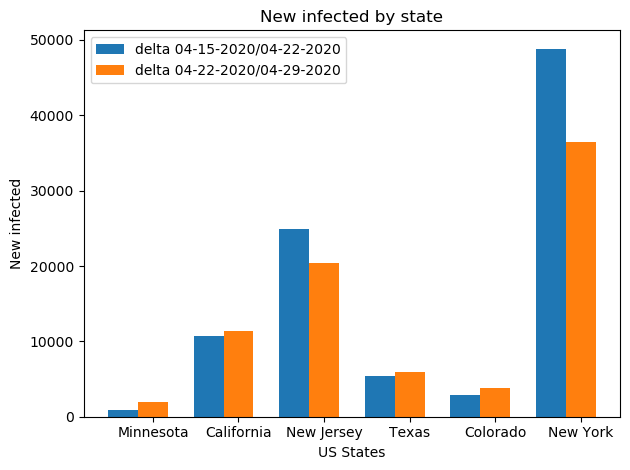

In [20]:
# create plot
fig, ax = plt.subplots()
index = np.arange(len(delta1))
bar_width = 0.35

rects1 = plt.bar(index, delta1, bar_width, label='delta {}/{}'.format(dates[0], dates[1]))

rects2 = plt.bar(index + bar_width, delta2, bar_width, label='delta {}/{}'.format(dates[1], dates[2]))

plt.xlabel('US States')
plt.ylabel('New infected')
plt.title('New infected by state')
plt.xticks(index + bar_width, tuple(states))
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
target_field = 'delta'
myRangeList = []

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())     
symbol.setColor(QColor(255, 255, 255))
myRange = QgsRendererRange(-20000, -10001, symbol, '<-10001')
myRangeList.append(myRange)

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())
symbol.setColor(QColor(255, 191, 191))
myRange = QgsRendererRange(-10000, -3501, symbol, '-10000:-3501')
myRangeList.append(myRange)

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())
symbol.setColor(QColor(255, 128, 128))
myRange = QgsRendererRange(-3500, -501, symbol, '-3500:-501')
myRangeList.append(myRange)

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())
symbol.setColor(QColor(255, 64, 64))
myRange = QgsRendererRange(-500, 1501, symbol, '-500:1501')
myRangeList.append(myRange)

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())
symbol.setColor(QColor(255, 0, 0))
myRange = QgsRendererRange(1500, 15000, symbol, '>1500')
myRangeList.append(myRange)

myRenderer = QgsGraduatedSymbolRenderer(target_field, myRangeList)
myRenderer.setMode(QgsGraduatedSymbolRenderer.Custom)               

usa_layer.setRenderer(myRenderer)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: QgsGraduatedSymbolRenderer.setMode() is deprecated


In [22]:
xt = usa_layer.extent()
# print(xt)
width  = 1000
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([usa_layer])
options.setBackgroundColor(QColor(104, 200, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
options.setDestinationCrs(usa_layer.crs())
options.destinationCrs()

render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()

Gerar mapa com 1000 por 162


Display an image of the evolution of the new infected

In [23]:
from IPython.display import Image

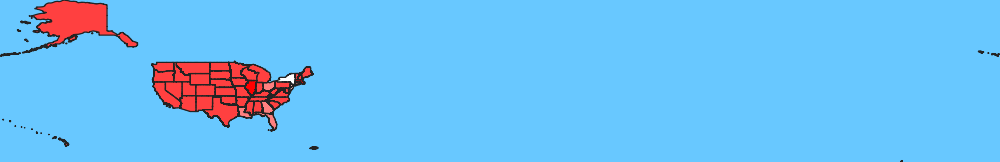

In [24]:
imgbuf = QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

In [25]:
qgs.exitQgis()